In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from pyFTS.benchmarks import Measures
from pyFTS.benchmarks import Measures
from pyFTS.common import Util
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import math
import statistics

import sys
sys.path.append("/home/hugo/projetos-doutorado/mimo_emb_fts/src/")

from embfts.util.DataSetUtil import DataSetUtil
from embfts.util.StatisticsUtil import StatisticsUtil

### Dataset

In [3]:
data_set_util = DataSetUtil()
statistics_util = StatisticsUtil()

df = pd.read_csv('/home/hugo/projetos-doutorado/mimo_emb_fts/data/energydata_complete.csv', sep=',')
data = df.drop(labels=['date','rv1','rv2'], axis=1)
data = data_set_util.clean_dataset(data)
#data = data_set_util.series_to_supervised_mimo(data, 1, 1)
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


In [18]:
nobs = 1
df_train, df_test = data[0:-nobs], data[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)


train = data_set_util.sample_first_prows(data,0.75)
test = data.iloc[max(train.index):]
print(train.shape)  # (119, 8)
print(test.shape)  # (4, 8)

(19734, 26)
(1, 26)
(14801, 26)
(4935, 26)


### How to Select the Order (P) of VAR model

In [41]:
# model = VAR(train)
# for i in [1,2,3,4,5,6,7,8,9]:
#     result = model.fit(i)
#     print('Lag Order =', i)
#     print('AIC : ', result.aic)
#     print('BIC : ', result.bic)
#     print('FPE : ', result.fpe)
#     print('HQIC: ', result.hqic, '\n')

In [42]:
# x = model.select_order(maxlags=12)
# x.summary()

In [43]:
model_fitted = model.fit()
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Jan, 2022
Time:                     22:16:21
--------------------------------------------------------------------
No. of Equations:         26.0000    BIC:                   -77.5532
Nobs:                     14800.0    HQIC:                  -77.7941
Log likelihood:           31256.6    FPE:                1.45367e-34
AIC:                     -77.9138    Det(Omega_mle):     1.38638e-34
--------------------------------------------------------------------
Results for equation Appliances
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 86.861963        84.166924            1.032           0.302
L1.Appliances          0.721663         0.005863          123.093           0.000
L1.lights              0.678896         0.077957   

In [44]:
# def adjust(val, length= 6): return str(val).ljust(length)

# from statsmodels.stats.stattools import durbin_watson
# out = durbin_watson(model_fitted.resid)

# for col, val in zip(data.columns, out):
#     print(adjust(col), ':', round(val, 2))

In [45]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = test.values
forecast_input.shape

1


(4935, 26)

In [63]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=len(forecast_input))
df_forecast = pd.DataFrame(fc,columns=test.columns)
df_forecast

# fc = model_fitted.forecast(model_fitted.y, steps=len(forecast_input))
# df_forecast = pd.DataFrame(fc,columns=test.columns)
# df_forecast

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,335.926485,7.746730,25.534434,47.120562,25.246144,43.281056,26.874529,41.461695,24.783302,46.033008,...,24.784045,49.676059,23.195423,46.801754,22.109100,755.191733,57.067016,3.988100,27.121980,13.135024
1,266.591213,6.086905,25.559852,47.452835,25.213041,43.586305,26.908415,41.717002,24.841615,46.096559,...,24.826308,49.640291,23.191317,46.774246,22.001600,755.179266,57.217342,3.975974,27.226191,13.069342
2,215.397658,4.866556,25.578023,47.649328,25.168878,43.881106,26.929790,41.932361,24.881649,46.153323,...,24.863949,49.623674,23.187634,46.759448,21.881977,755.163566,57.430347,3.963817,27.318732,13.003434
3,177.514866,3.970968,25.590267,47.748436,25.116506,44.161757,26.942146,42.115213,24.908317,46.203023,...,24.897830,49.622356,23.184338,46.755013,21.753508,755.145355,57.690826,3.951763,27.403981,12.937640
4,149.403495,3.314772,25.597580,47.778225,25.058018,44.426227,26.948028,42.271271,24.925219,46.245643,...,24.928590,49.633355,23.181399,46.759102,21.618599,755.125169,57.987538,3.939905,27.485050,12.872204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4930,98.717754,4.125729,21.329669,39.776718,19.756827,40.425900,21.798815,38.964534,20.422597,38.426500,...,21.806133,42.174551,19.073608,41.132779,6.183732,757.015158,80.500128,4.031252,38.834763,2.785304
4931,98.717809,4.125730,21.329670,39.776717,19.756828,40.425898,21.798817,38.964532,20.422598,38.426493,...,21.806138,42.174544,19.073610,41.132768,6.183715,757.015026,80.500161,4.031248,38.834740,2.785293
4932,98.717864,4.125730,21.329671,39.776717,19.756829,40.425896,21.798818,38.964531,20.422599,38.426487,...,21.806142,42.174538,19.073613,41.132757,6.183698,757.014895,80.500194,4.031245,38.834717,2.785282
4933,98.717919,4.125730,21.329672,39.776717,19.756829,40.425894,21.798820,38.964530,20.422599,38.426480,...,21.806146,42.174532,19.073615,41.132745,6.183681,757.014763,80.500227,4.031242,38.834694,2.785271


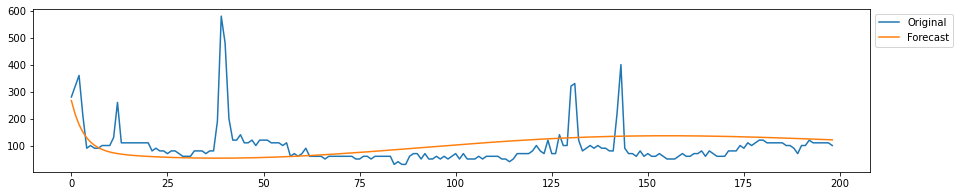

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
ax.plot(test.loc[:,'Appliances'].values[1:200], label='Original')
ax.plot(df_forecast.loc[:,'Appliances'].values[1:200], label='Forecast')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
plt.show()

Appliances
RMSE :  88.66316939007501, R2 :  -0.00793760044831382, MAE :  52.89079106568672, 

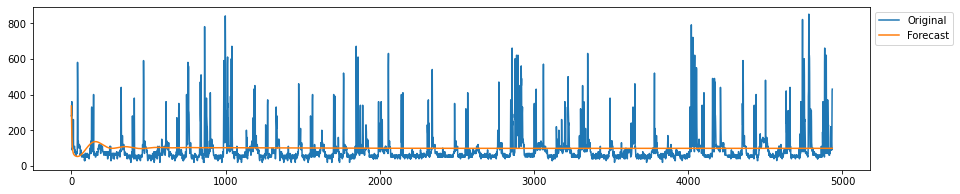


lights
RMSE :  5.889083993592833, R2 :  -0.12540373275411998, MAE :  4.55418967303309, 

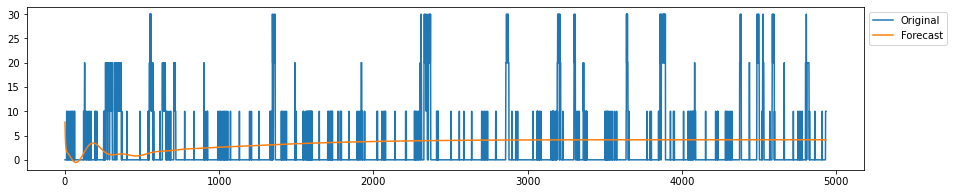


T1
RMSE :  2.590601855850653, R2 :  -2.18256585363157, MAE :  2.3670258598260014, 

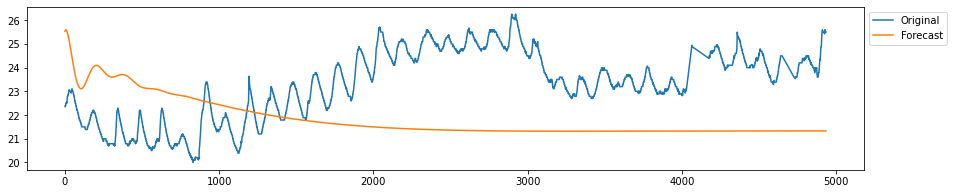


RH_1
RMSE :  5.060157033803428, R2 :  -0.014721124274532649, MAE :  3.808749995517758, 

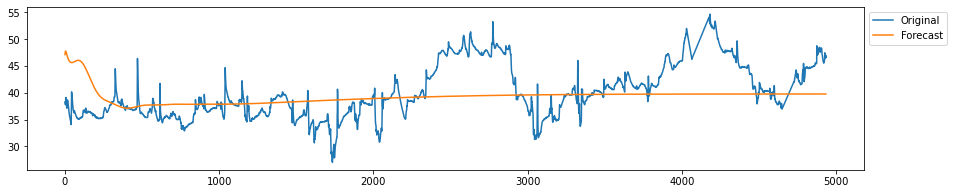


T2
RMSE :  3.7600714267400988, R2 :  -1.1438546513179402, MAE :  3.2146290756981952, 

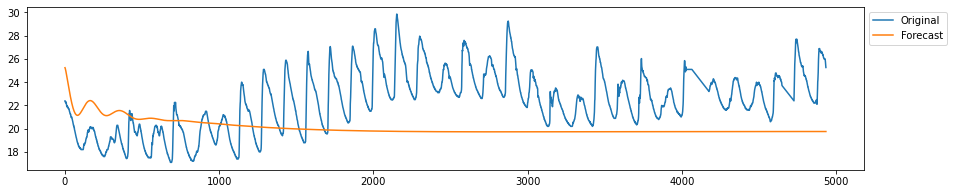


RH_2
RMSE :  5.676862055160342, R2 :  -0.04962004202177339, MAE :  4.536529754358504, 

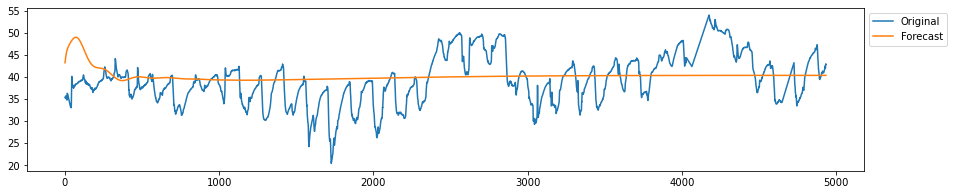


T3
RMSE :  3.2946279855841123, R2 :  -2.8681184075310178, MAE :  2.941085996553661, 

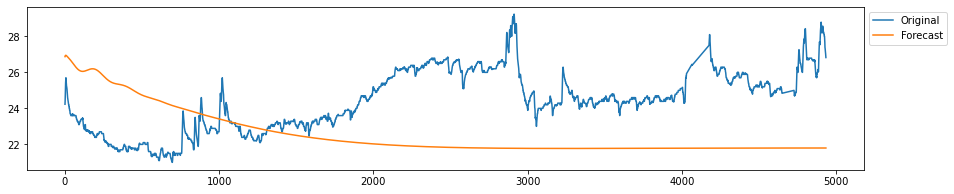


RH_3
RMSE :  3.1493501642021657, R2 :  0.14711172502191494, MAE :  2.3004688905399435, 

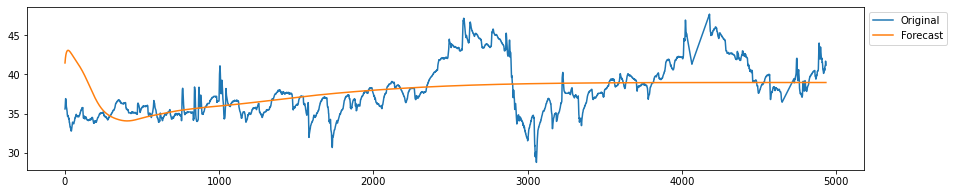


T4
RMSE :  3.3299790704929815, R2 :  -2.70565078914523, MAE :  3.141648512154925, 

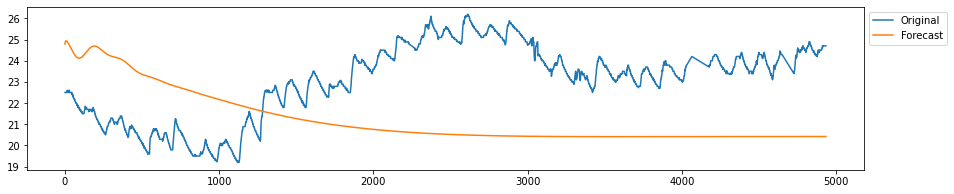


RH_4
RMSE :  4.595194699735508, R2 :  -0.0027090239108311653, MAE :  3.538456073921198, 

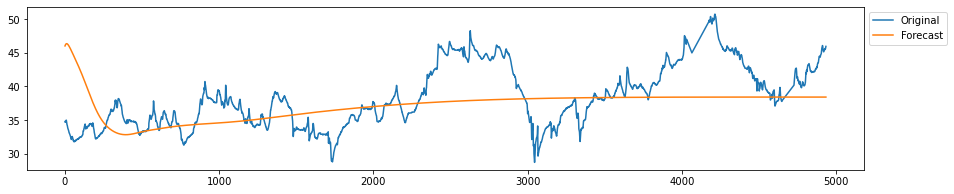


T5
RMSE :  3.1135848329846816, R2 :  -2.2921462252160185, MAE :  2.768640692201052, 

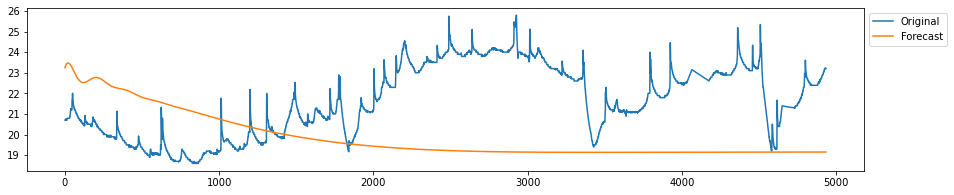


RH_5
RMSE :  8.885635224618316, R2 :  -0.012886786755718083, MAE :  6.1571310477589725, 

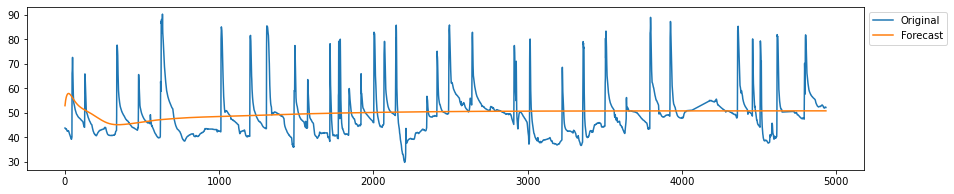


T6
RMSE :  9.9783985099096, R2 :  -1.2180953658407443, MAE :  8.471207996202114, 

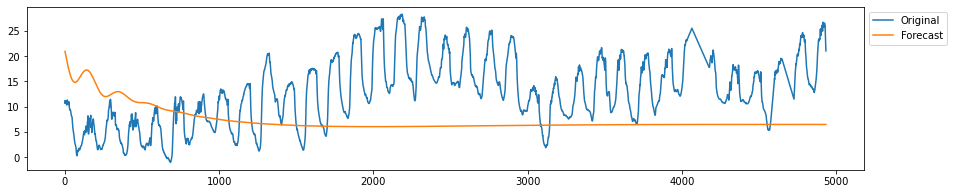


RH_6
RMSE :  38.76067313163274, R2 :  -2.5159198142381323, MAE :  33.64589682550211, 

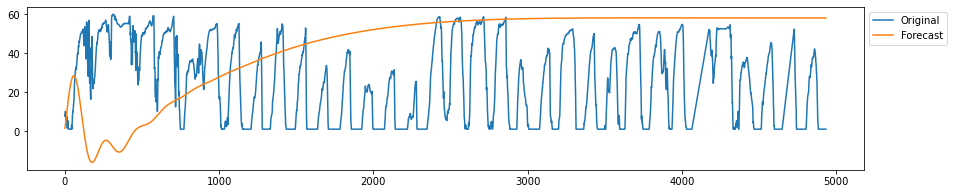


T7
RMSE :  3.442536571407358, R2 :  -2.671136641210449, MAE :  3.2668647891411107, 

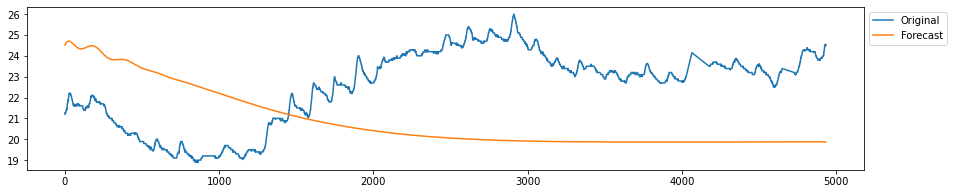


RH_7
RMSE :  5.675145085257307, R2 :  -0.12539308549980244, MAE :  4.461937840516812, 

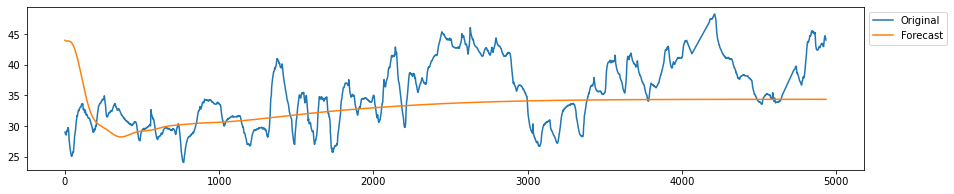


T8
RMSE :  2.6712012919164296, R2 :  -2.819330353000134, MAE :  2.410790826851866, 

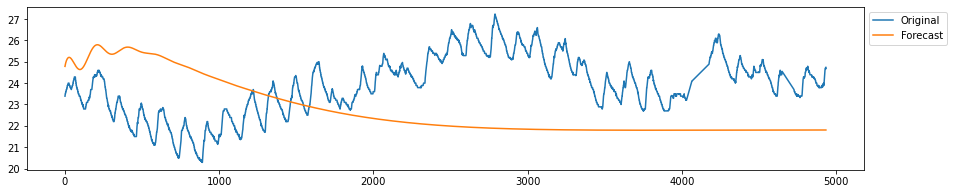


RH_8
RMSE :  5.372968388858401, R2 :  -0.11202355194146318, MAE :  4.26114023876539, 

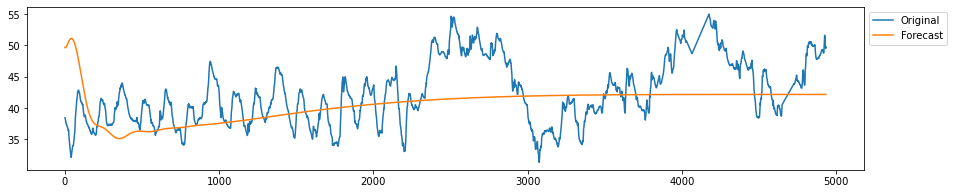


T9
RMSE :  3.4237571134844655, R2 :  -3.074574090025334, MAE :  3.1851594385228172, 

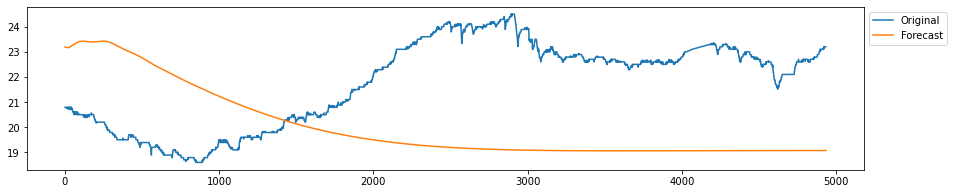


RH_9
RMSE :  4.526913366766684, R2 :  0.06628396345491405, MAE :  3.5388213391078853, 

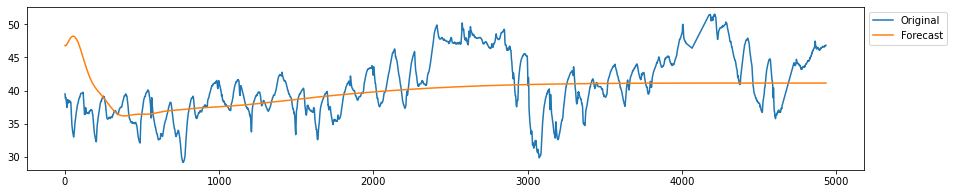


T_out
RMSE :  8.724078120223732, R2 :  -1.3076101130265965, MAE :  7.449501937470296, 

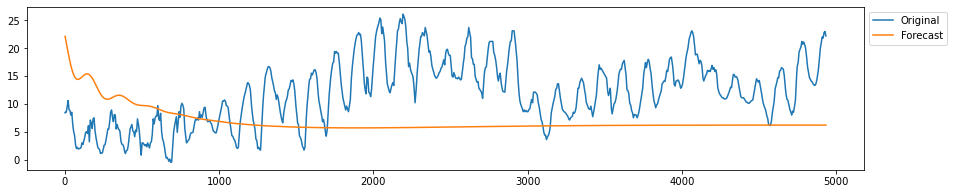


Press_mm_hg
RMSE :  6.256196689793686, R2 :  -0.39296262796345016, MAE :  5.010485363949118, 

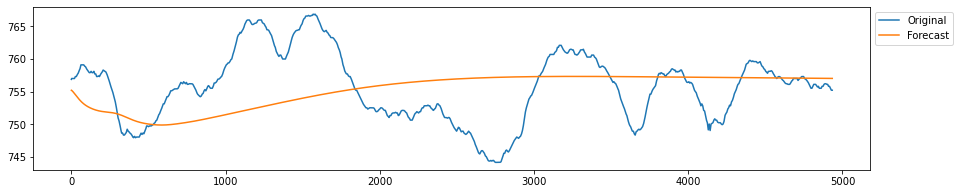


RH_out
RMSE :  20.025792724668666, R2 :  -0.20153258284515596, MAE :  16.24694557370597, 

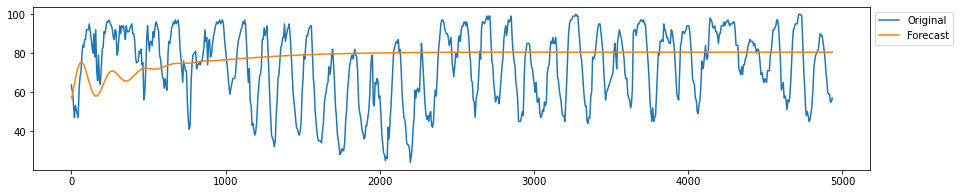


Windspeed
RMSE :  1.8806416359750366, R2 :  -0.18659670730187417, MAE :  1.535456629840906, 

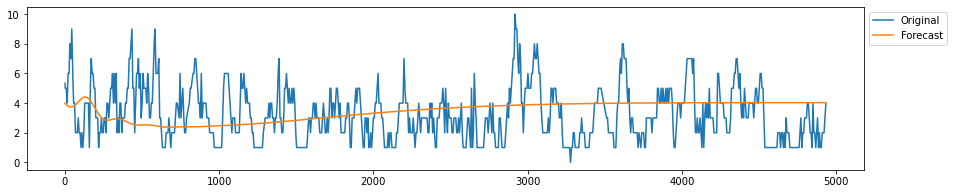


Visibility
RMSE :  8.917631207766755, R2 :  -0.06913466654447742, MAE :  6.344830093120832, 

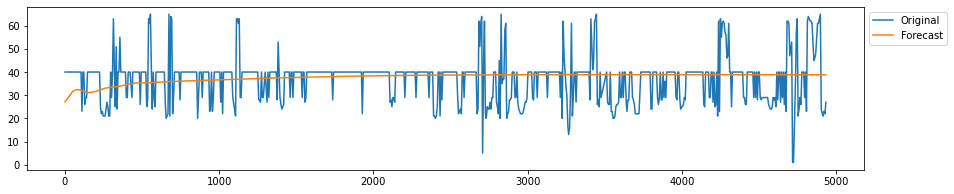


Tdewpoint
RMSE :  6.395514208398149, R2 :  -1.0055459374628328, MAE :  5.324598696223471, 

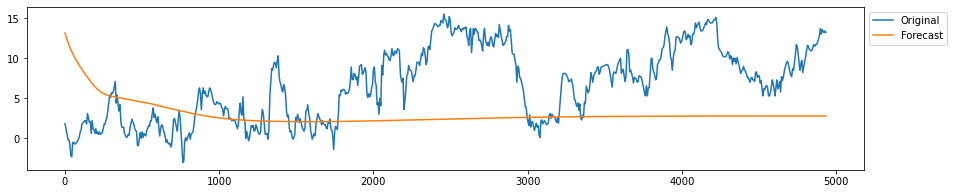

In [65]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
 
# original = original[:len(original)-1]
# forecast = forecast[1:]  

forecast_df = pd.DataFrame(df_forecast,columns=list(test.columns))

validation_df = test
    
for index,i in enumerate(validation_df.columns):
    print(i)
    
    original = validation_df[i].values
    forecast = forecast_df[i].values
    #forecast2 = forecast_e2d2[i].values
    #original = original[:len(original)-1]
    #forecast = forecast[1:]
#     forecast2 = forecast2[1:]
    
    print("RMSE : ",mean_squared_error(original,forecast,squared=False),end=", ")
    print("R2 : ",r2_score(original,forecast),end=", ")
    print("MAE : ",mean_absolute_error(original,forecast),end=", ")
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
    ax.plot(original, label='Original')
    ax.plot(forecast, label='Forecast')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
    plt.show()
    
    print()